# Moving Averge-based Trading Strategy

In [56]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plot
from datetime import datetime
import time

# ----- User Settings 
coin='CRV'

initial_coin = 1
initial_usd = 0
trading_fee = 0.01
 
collectDataFrom = datetime(2019, 1, 1)
#buyAbove='sma7d'
buyAbove='sma50d'
#buyAbove='sma200d'
cryptocompare_api_key='777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'


# ----- User Settings -- end


timestamp = time.time()

time_segments = []
limit=1000

while datetime.timestamp(collectDataFrom) <= timestamp : 
    requestString = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&limit={}&api_key={}&toTs={}'\
    .format(coin, limit, cryptocompare_api_key, timestamp)
    # print("Request : " + requestString)    
    response = requests.get(requestString).text 
    parsed = json.loads(response)
    segment_df = pd.DataFrame(parsed['Data']['Data'])
    prev_timestamp = timestamp
    timestamp = segment_df.loc[0]['time']
    time_segments.append(segment_df)
df= pd.concat(time_segments , axis=0)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.sort_values(by=['time'], inplace=True)
df.drop_duplicates(inplace=True)
df.set_index('time',inplace=True, verify_integrity = True, drop = True)
df.drop(['volumefrom', 'volumeto','conversionType','conversionSymbol'], axis=1, inplace=True)

df


,high,low,open,close
time,,,,
2017-06-30,0.0000,0.0000,0.0000,0.0000
2017-07-01,0.0000,0.0000,0.0000,0.0000
2017-07-02,0.0000,0.0000,0.0000,0.0000
2017-07-03,0.0000,0.0000,0.0000,0.0000
2017-07-04,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...
2022-12-17,0.5634,0.5315,0.5430,0.5604
2022-12-18,0.5630,0.5439,0.5604,0.5489
2022-12-19,0.5721,0.5146,0.5489,0.5165


In [57]:
#--- Adding 'date' date field 
#def unix_to_date(u_time):
#        return datetime.utcfromtimestamp(u_time).strftime('%Y-%m-%d')
#print(type(df))    
#df['date'] = df['time'].map(unix_to_date)
# -- Reorder to have date on the second position
#df = df[['time', 'date', 'open', 'close', 'low', 'high']]
# -- Filter out the older not required dates
#filt = (df['time'] >= collectDataFrom)
#df=df[filt]
df=df.loc[collectDataFrom:]
df

,high,low,open,close
time,,,,
2019-01-01,0.0000,0.0000,0.0000,0.0000
2019-01-02,0.0000,0.0000,0.0000,0.0000
2019-01-03,0.0000,0.0000,0.0000,0.0000
2019-01-04,0.0000,0.0000,0.0000,0.0000
2019-01-05,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...
2022-12-17,0.5634,0.5315,0.5430,0.5604
2022-12-18,0.5630,0.5439,0.5604,0.5489
2022-12-19,0.5721,0.5146,0.5489,0.5165


In [58]:
# Adding Simple Moving Average Columns
df['sma7d'] = df['close'].rolling(7).mean()
df['sma50d'] = df['close'].rolling(50).mean()
df['sma200d'] = df['close'].rolling(200).mean()

# Adding ExponentialMoving Average Columns

df['ema21w'] = df['close'].ewm(span=21*7, adjust=False).mean()

df




,high,low,open,close,sma7d,sma50d,sma200d,ema21w
time,,,,,,,,
2019-01-01,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.000000
2019-01-02,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.000000
2019-01-03,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.000000
2019-01-04,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.000000
2019-01-05,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...
2022-12-17,0.5634,0.5315,0.5430,0.5604,0.609957,0.692254,0.950716,0.938116
2022-12-18,0.5630,0.5439,0.5604,0.5489,0.598557,0.684528,0.947125,0.932856
2022-12-19,0.5721,0.5146,0.5489,0.5165,0.583957,0.676714,0.943433,0.927229


In [59]:
df['hold'] =  df['sma50d'] < df['close']

df['growth'] = df['close'].rolling(window=2).apply(lambda x: x.iloc[1] / x.iloc[0])
df['prev_close'] = df['close'].rolling(window=2).apply(lambda x: x.iloc[0])
df = df.dropna()
df.insert(len(df.columns),'usd_bag',initial_usd)
df.insert(len(df.columns),'coin_bag',initial_coin)
               

In [60]:


def trade_by_ma(row, ma_column='sma50d'):

    isAboveSMA = row['close'] > row[ma_column]
    coin_bag = row['coin_bag']
    usd_bag = row['usd_bag']
    if (isAboveSMA == True ):
    
        if (usd_bag>0):
            coin_bag =  row['coin_bag'] + (1-trading_fee) * row['usd_bag']/row['close']  
            usd_bag = 0
    else:
        if (coin_bag>0):
            usd_bag = row['usd_bag'] + (1-trading_fee) * row['coin_bag']*row['close']
            coin_bag = 0
    return coin_bag,usd_bag 


usd_bag=initial_usd
coin_bag=initial_coin

for index, row in df.iterrows():

    row['coin_bag'] = coin_bag
    row['usd_bag'] = usd_bag
    coin_bag, usd_bag = trade_by_ma(row, ma_column=buyAbove)
    df.loc[index,'coin_bag'] = coin_bag
    df.loc[index,'usd_bag'] = usd_bag
df['usd_value'] = df['usd_bag'] + df['coin_bag']*df['close']
df['hodl_usd_value'] = df['close']*initial_coin + initial_usd
df['success_rate'] = df['usd_value'] / df['hodl_usd_value'] 
df.tail(1)

,high,low,open,close,sma7d,sma50d,sma200d,ema21w,hold,growth,prev_close,usd_bag,coin_bag,usd_value,hodl_usd_value,success_rate
time,,,,,,,,,,,,,,,,
2022-12-21,0.5357,0.5083,0.5278,0.5112,0.546529,0.66196,0.936873,0.916283,False,0.968549,0.5278,0.324734,0.0,0.324734,0.5112,0.635238


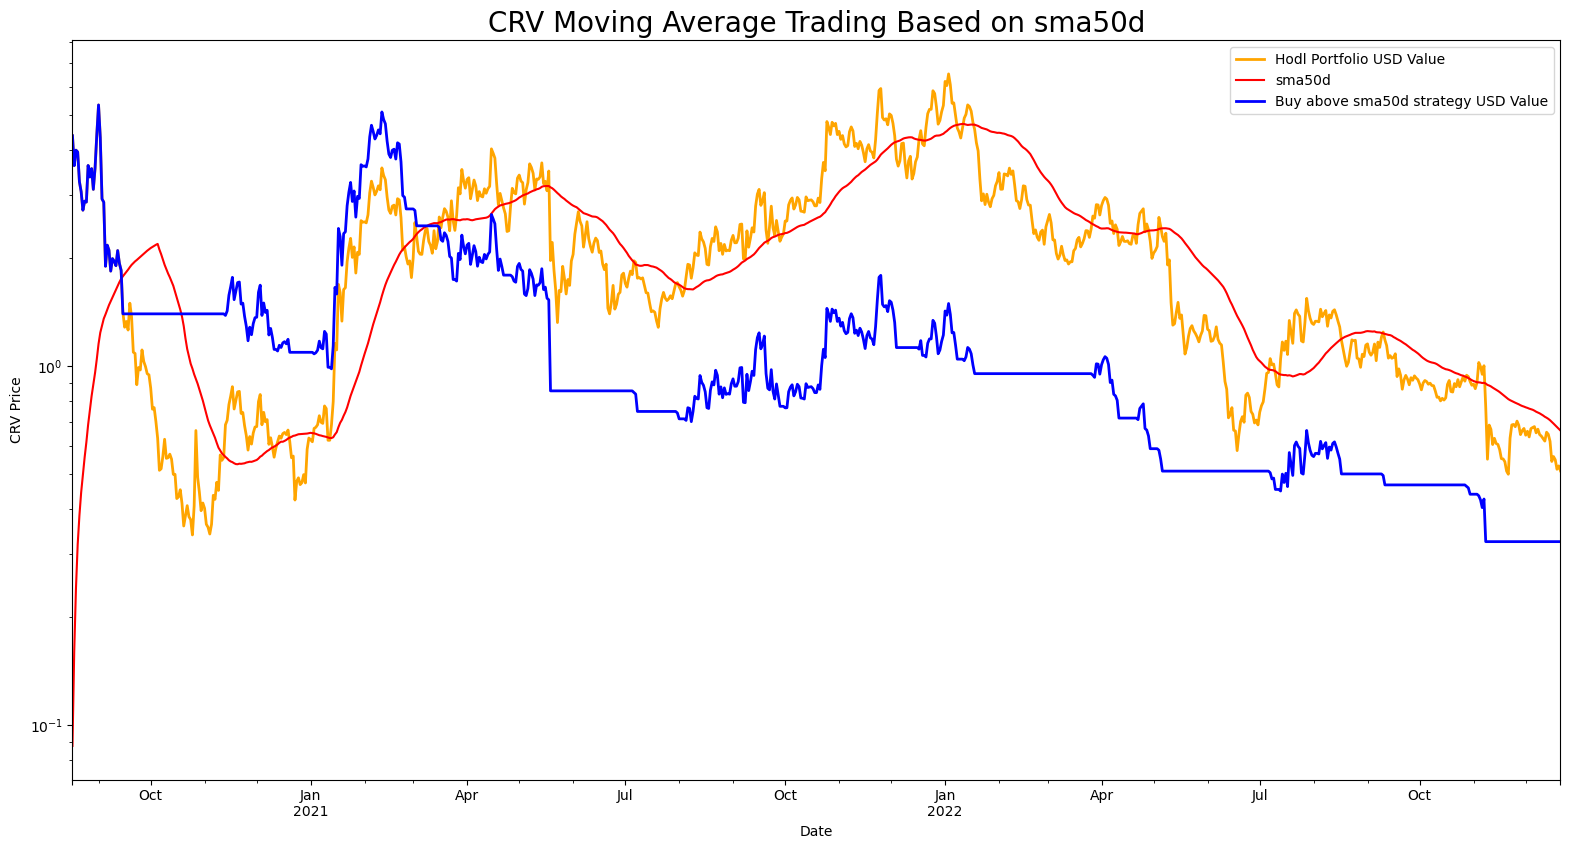

In [61]:

df['close'].plot(c='orange',label='Hodl Portfolio USD Value',linewidth=2)
df[buyAbove].plot(c='red',label=buyAbove)
df['usd_value'].plot(c='blue',label='Buy above {} strategy USD Value'.format(buyAbove),linewidth=2)


plot.title("{} Moving Average Trading Based on {}".format(coin, buyAbove), fontsize=20)
plot.ylabel("{} Price".format(coin))
plot.xlabel('Date')
plot.legend()
plot.yscale('log')
F = plot.gcf()

# Now check everything with the defaults:
#DPI = F.get_dpi()
#print ("DPI:", DPI)
DefaultSize = F.get_size_inches()
#print ("Default size in Inches", DefaultSize)
#print ("Which should result in a %i x %i Image"%(DPI*DefaultSize[0], DPI*DefaultSize[1]))
# the default is 100dpi for savefig:
#F.savefig("test1.png")
# this gives me a 797 x 566 pixel image, which is about 100 DPI

# Now make the image twice as big, while keeping the fonts and all the
# same size
F.set_size_inches( (DefaultSize[0]*3, DefaultSize[1]*2) )

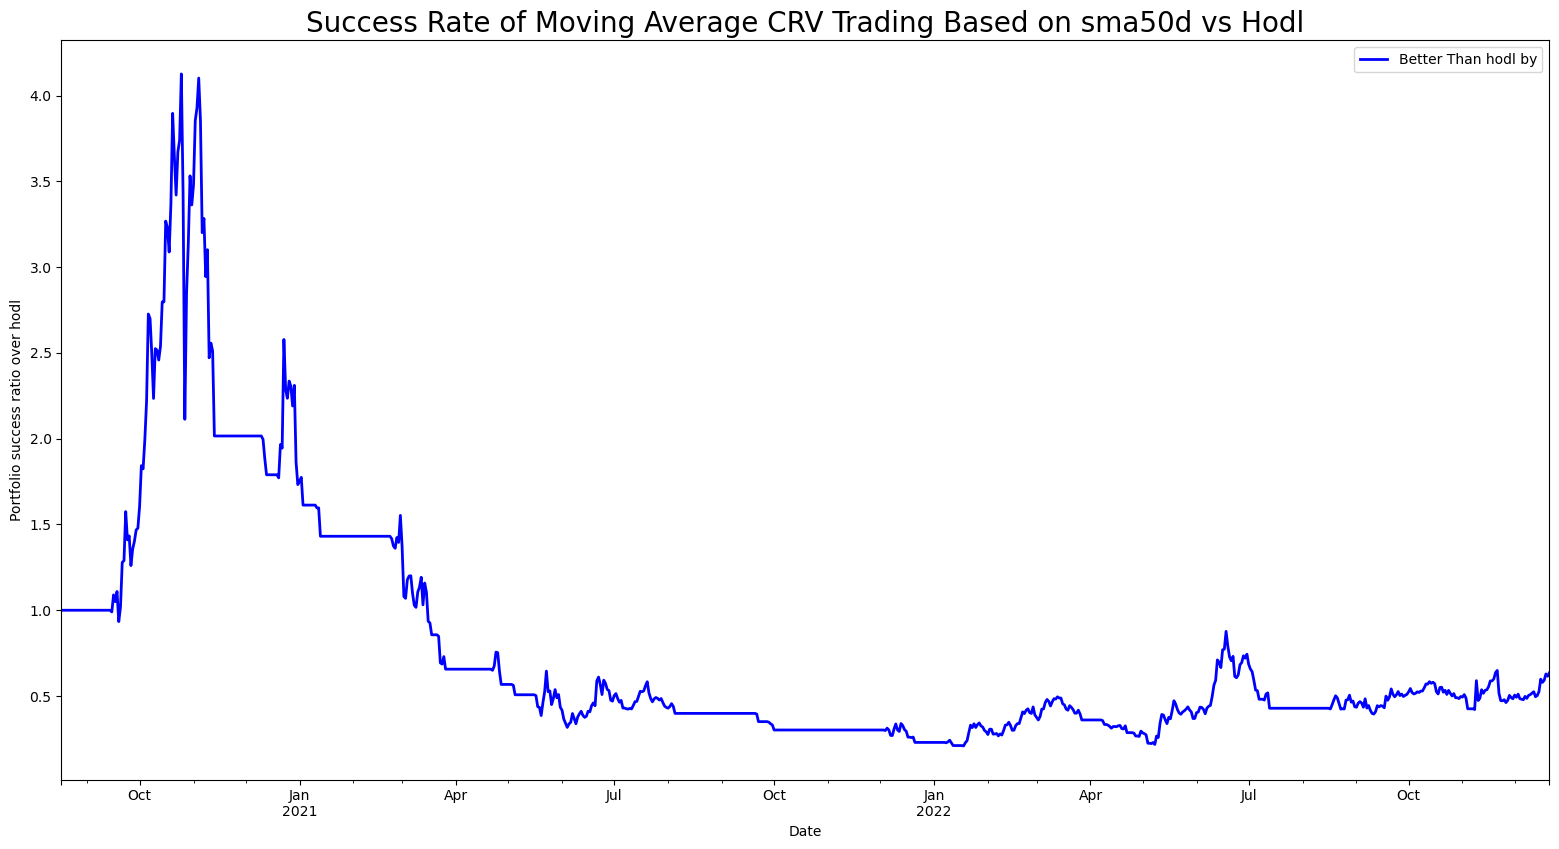

In [62]:

df['success_rate'].plot(c='blue',label='Better Than hodl by',linewidth=2)


plot.title("Success Rate of Moving Average {} Trading Based on {} vs Hodl".format(coin, buyAbove), fontsize=20)
plot.ylabel("Portfolio success ratio over hodl")
plot.xlabel('Date')
plot.legend()
F = plot.gcf()
DefaultSize = F.get_size_inches()

F.set_size_inches( (DefaultSize[0]*3, DefaultSize[1]*2) )